### ANTES DE EMPEZAR

In [35]:
# Uncomment to upgrade packages
# !pip3 install pandas --upgrade --quiet
# !pip3 install numpy --upgrade --quiet
# !pip3 install scipy  --upgrade --quiet
# !pip3 install statsmodels  --upgrade --quiet
# !pip3 install seaborn  --upgrade --quiet
# !pip3 install matplotlib  --upgrade --quiet
# !pip3 install scikit-learn  --upgrade
# !pip install scikit-optimize  --quiet
#!pip install apafib --upgrade  --quiet
#!pip install pmlb --upgrade  --quiet

In [36]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

init_time = time()

In [37]:
import pandas as pd
from pandas import read_csv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB

from sklearn.model_selection import GridSearchCV

from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [38]:
def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()


In [39]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

In [40]:
class NASDAQ(Dataset):
    def __init__(self, data, pred):
        self.data = torch.Tensor(data).float()
        self.pred = torch.Tensor(pred).float().unsqueeze(1)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.pred[index]

        return x, y

    def __len__(self):
        return len(self.data)

#  BCN_train = torch.utils.data.DataLoader(BCNAir(X_train, y_train), batch_size=32)

In [41]:
# Funcion para entrenar el modelo
def train_loop(model, train, val, optimizer, patience=5, epochs=100):
    """_Bucle de entrenamiento_

    Args:
        model: red a entrenal
        optimizer: optimizador de pytorch, por ejemplo torch.optim.Adam
        train: datos de entrenamiento
        val: datos de validacion
        epochs: numero de epochs

    Returns:
        _type_: _description_
    """
    def epoch_loss(dataset):
        data_loss = 0.0
        for i, (data, labels) in enumerate(dataset):
            inputs = data.to('cuda')
            y = labels.to('cuda')
            outputs = model(inputs)
            loss = F.mse_loss(outputs, y, reduction="mean")
            data_loss += loss.item()
        return data_loss / i

    def early_stopping(val_loss, patience=5):
        if len(val_loss) > patience:
            if val_loss[-1] > val_loss[-(patience+1)]:
                return True

    hist_loss = {'train': [], 'val': []}
    pbar = tqdm(range(epochs))
    for epoch in pbar:  # bucle para todos los epochs
        for i, (data, labels) in enumerate(train):
            # obtenemos los datos y los subimos a la GPU
            inputs = data.to('cuda')
            y = labels.to('cuda')

            # Reiniciamos los gradientes
            optimizer.zero_grad()

            # Aplicamos los datos al modelo
            outputs = model(inputs)
            # Calculamos la perdida
            loss = F.mse_loss(outputs, y, reduction="mean")

            # Hacemos el paso hacia atras
            loss.backward()
            optimizer.step()

        # Calculamos la perdida en el conjunto de entrenamiento y validacion
        with torch.no_grad():
            hist_loss['train'].append(epoch_loss(train))
            hist_loss['val'].append(epoch_loss(val))

        # Mostramos la perdida en el conjunto de entrenamiento y validacion
        pbar.set_postfix({'train': hist_loss['train'][-1], 'val': hist_loss['val'][-1]})

        # Si la perdida en el conjunto de validacion no disminuye, paramos el entrenamiento
        if early_stopping(hist_loss['val'], patience):
            break

    return hist_loss

# Para el optimizador podemos usar Adam, le pasaremos el siguiente objeto
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# donde model es el modelo que queremos entrenar
# y lr es la tasa de aprendizaje, 1e-4 es un valor comun

In [42]:
# Clase para definir la arquitectura del MLP
class MLP(nn.Module):
    def __init__(self, input_size,  hidden_layers_sizes, activation=nn.ReLU):
        super(MLP, self).__init__()
        self.layers = []
        self.fc1 = nn.Linear(input_size, hidden_layers_sizes[0])
        self.layers.append(self.fc1)
        self.layers.append(activation())
        for i in range(1, len(hidden_layers_sizes)):
            self.layers.append(nn.Linear(hidden_layers_sizes[i-1], hidden_layers_sizes[i]))
            self.layers.append(activation())
        self.layers = nn.Sequential(*self.layers)
        self.output = nn.Linear(hidden_layers_sizes[-1], 1)

    def forward(self, x):
        return self.output(self.layers(x.view(x.size(0), -1)))

In [43]:
def test_model(model, test):
    """_Funcion para obtener las predicciones de un modelo en un conjunto de test_

    Poner el modelo en modo evaluacion antes de llamar a esta funcion

    Args:
        model: _modelo entrenado_
        test: _conjunto de test_

    Returns:
        _type_: _valores predichos, valores reales_
    """
    preds = []
    true = []
    for i, (data, val) in enumerate(test):
        inputs = data.to('cuda')
        outputs = model(inputs)
        preds.append(outputs.detach().cpu().numpy())
        true.append(val.detach().cpu().numpy())
    return np.concatenate(preds), np.concatenate(true)

# PROBLEMA 4 LISTA 3

### CARGA DE LOS DATOS

In [44]:
try:
  from apafib import load_Google
  data = load_Google()

except:
  print("No se ha podido cargar el dataset")

### APARTADO A

In [45]:
data.head()

data.columns

,GOOGLE-P,GOOGLE-V,GOOGLE-GAP,MSFT-P,MSFT-V,MSFT-GAP,AAPL-P,AAPL-V,AAPL-GAP,INTEL-P,INTEL-V,INTEL-GAP,AMD-P,AMD-V,AMD-GAP
Date,,,,,,,,,,,,,,,
2017-08-21,45.333,18846560,0.480,72.15,17698800,0.78,39.303,105320280,0.695,34.92,26479700,0.58,12.05,58786300,0.560
2017-08-22,46.234,23326400,0.719,73.16,14333220,0.89,39.945,86259560,0.495,34.65,26093400,0.57,12.17,38946780,0.230
2017-08-23,46.350,21771500,0.528,72.72,13758650,0.62,39.995,77507760,0.398,34.66,19775620,0.43,12.48,44193270,0.585
2017-08-24,46.064,25323820,0.767,72.69,17097240,0.79,39.818,79128680,0.547,34.71,14283180,0.34,12.50,37161680,0.320
2017-08-25,45.794,21055280,0.503,72.82,12790300,0.87,39.965,100738400,0.322,34.67,14714810,0.35,12.43,29650370,0.320


Index(['GOOGLE-P', 'GOOGLE-V', 'GOOGLE-GAP', 'MSFT-P', 'MSFT-V', 'MSFT-GAP',
       'AAPL-P', 'AAPL-V', 'AAPL-GAP', 'INTEL-P', 'INTEL-V', 'INTEL-GAP',
       'AMD-P', 'AMD-V', 'AMD-GAP'],
      dtype='object')

Como vemos a primera vista despues de cargar los datos tenemos 15 variables corrspondientes a 5 empresas con diferentes valors de sus acciones. Tenemos la variable "Empresa"_P que nos dice el valor de la accion al final del dia, la variable "Empresa"_V que nos dice el volumen de acciones que se intercambiaron y la variable "Empresa"_GAP que representa la diferencia entre el mayor y el menor precio de cotizacion en el dia X. Para este problema intentaremos predecir la evolucion del precio de la accion de Google (GOOGLE_P)

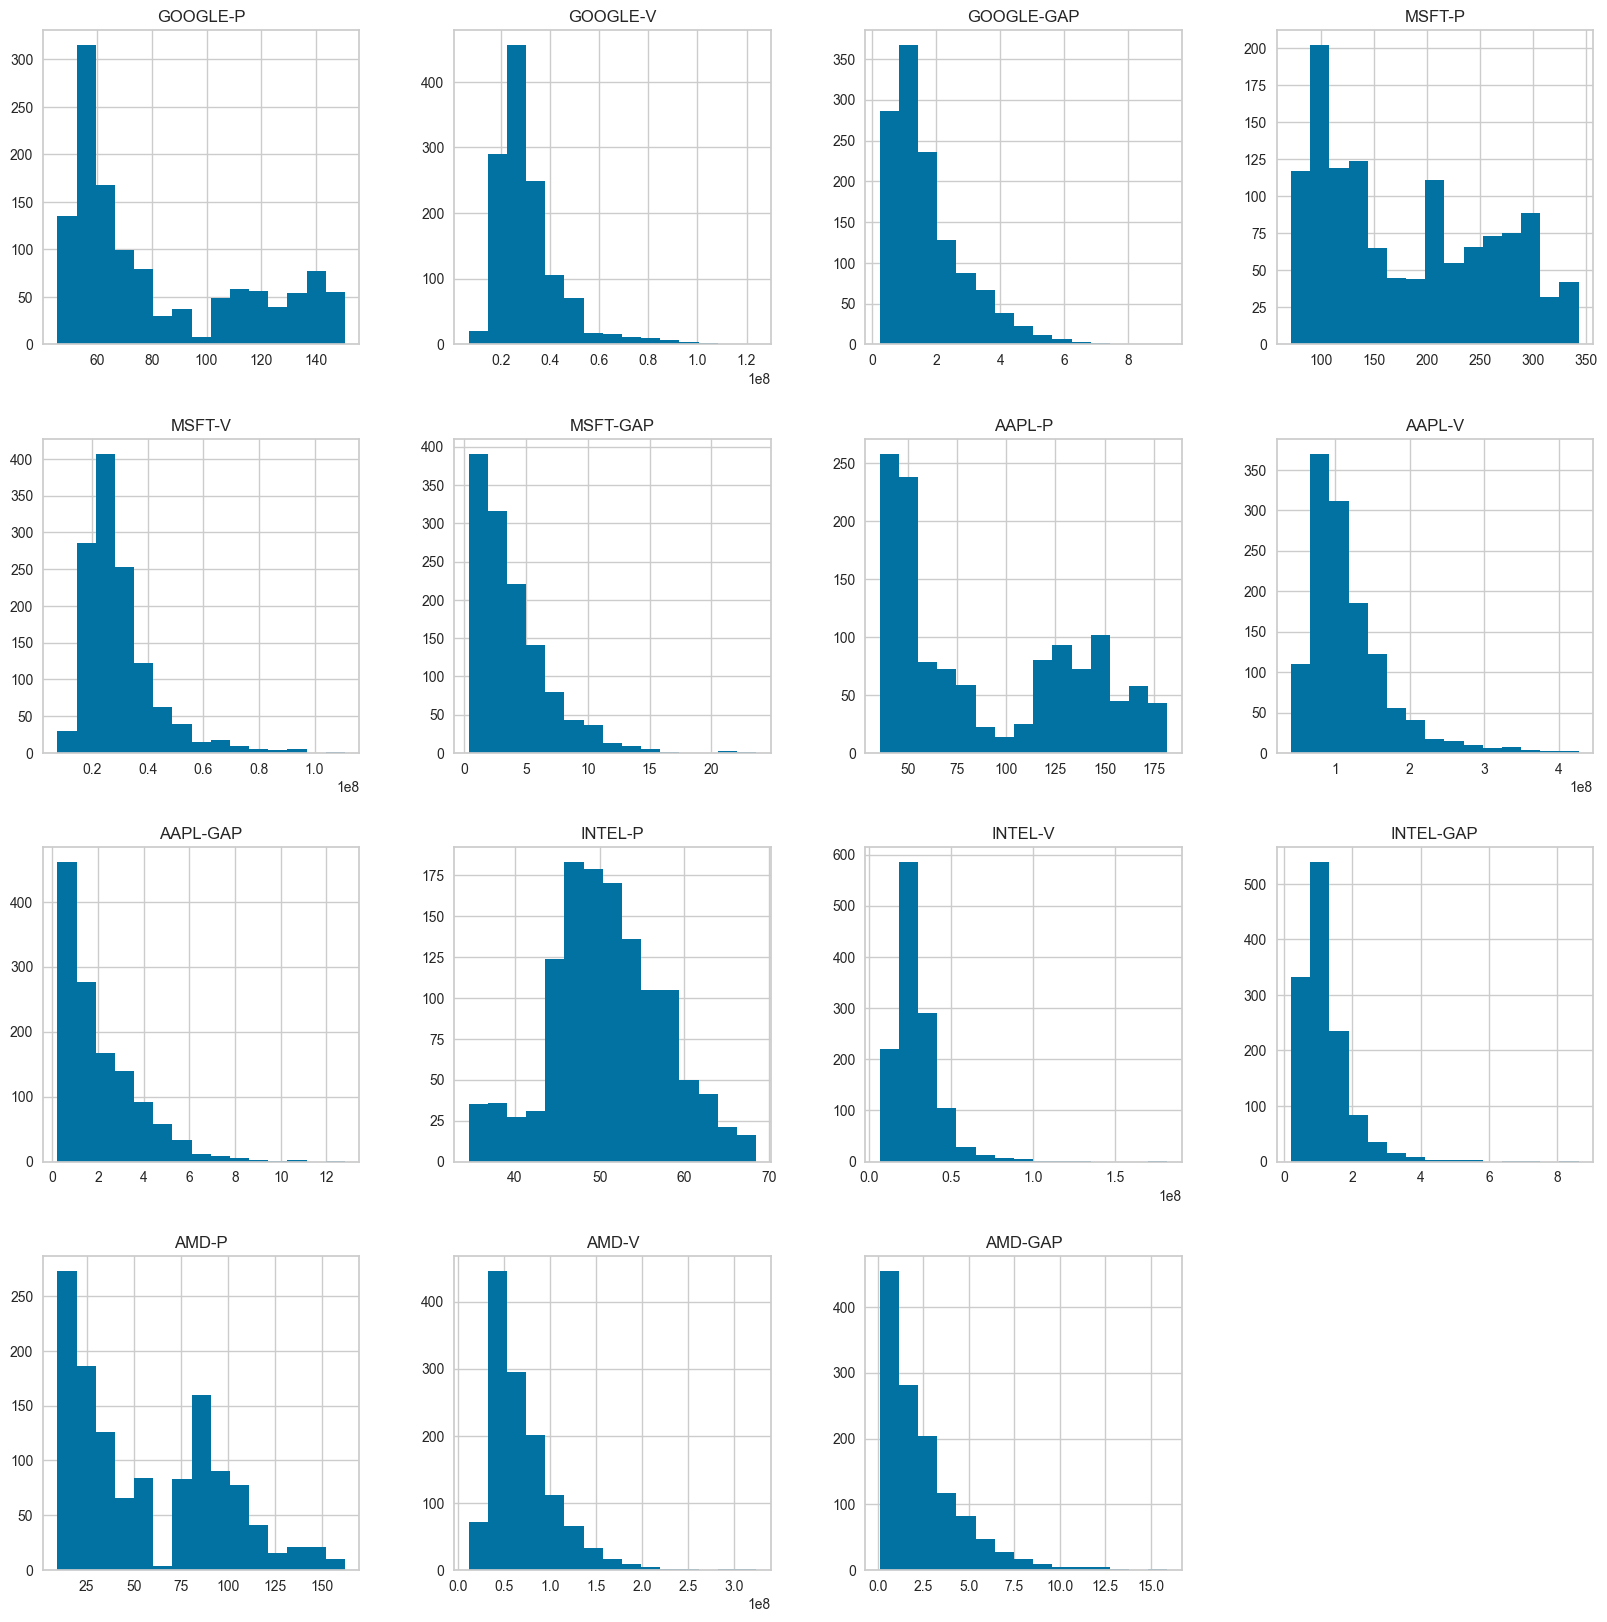

In [46]:
data.hist(bins=15, figsize=(20,20));

Al hacer el plot de los histogramas generados por las diferentes variables, no podemos observar nada muy interesante. Podemos ver mas o menos cual ha sido el valor mas comun de las diferentes acciones, por ejemplo de google esta alrededor de 60 y su valor maximo rondaria los 140. Vemos ademas que los valores no acaban de seguir una distribucion muy normal pero no tendria porque haber ningun inconveniente. Vamos a observar la media de los valores, asi como sus maximos y minimos.

In [47]:
data.describe()

,GOOGLE-P,GOOGLE-V,GOOGLE-GAP,MSFT-P,MSFT-V,MSFT-GAP,AAPL-P,AAPL-V,AAPL-GAP,INTEL-P,INTEL-V,INTEL-GAP,AMD-P,AMD-V,AMD-GAP
count,1259.000,1.259e+03,1259.000,1259.000,1.259e+03,1259.000,1259.000,1.259e+03,1259.000,1259.000,1.259e+03,1259.000,1259.000,1.259e+03,1259.000
mean,82.353,3.092e+07,1.740,181.821,2.954e+07,3.813,90.351,1.185e+08,2.068,50.895,2.901e+07,1.217,56.722,6.916e+07,2.409
std,32.321,1.348e+07,1.210,78.621,1.299e+07,2.913,46.269,5.504e+07,1.694,6.684,1.464e+07,0.739,38.704,3.596e+07,2.178
min,45.333,6.935e+06,0.238,72.150,7.426e+06,0.340,35.547,4.100e+07,0.214,34.520,6.313e+06,0.210,9.530,1.104e+07,0.120
25%,56.103,2.257e+07,0.871,108.150,2.125e+07,1.660,47.483,8.194e+07,0.776,46.720,1.978e+07,0.760,21.665,4.332e+07,0.820
50%,67.365,2.773e+07,1.371,163.490,2.629e+07,3.060,71.933,1.043e+08,1.502,50.590,2.585e+07,1.027,48.210,5.860e+07,1.720
75%,112.942,3.531e+07,2.219,252.485,3.374e+07,5.141,133.640,1.383e+08,2.925,55.380,3.400e+07,1.450,87.095,8.561e+07,3.295
max,150.709,1.239e+08,9.215,343.110,1.109e+08,23.640,182.010,4.269e+08,12.810,68.470,1.823e+08,8.620,161.910,3.238e+08,15.900


Nos fijamos en los valors medios de las acciones. Para el caso de google es de 82 con un valor maximo de 150, mas o menos como observavamos en los histogramas. Por otro lado el la media del GAP esta en 1.7 con un maximo de 9. Microsoft es la empresa con la media de GAP mas alta mientras que apple es la empresa con lea media de volumen mas alta. La empresa que tiene el mayor precio de mercado de sus accione, la media, es microsoft

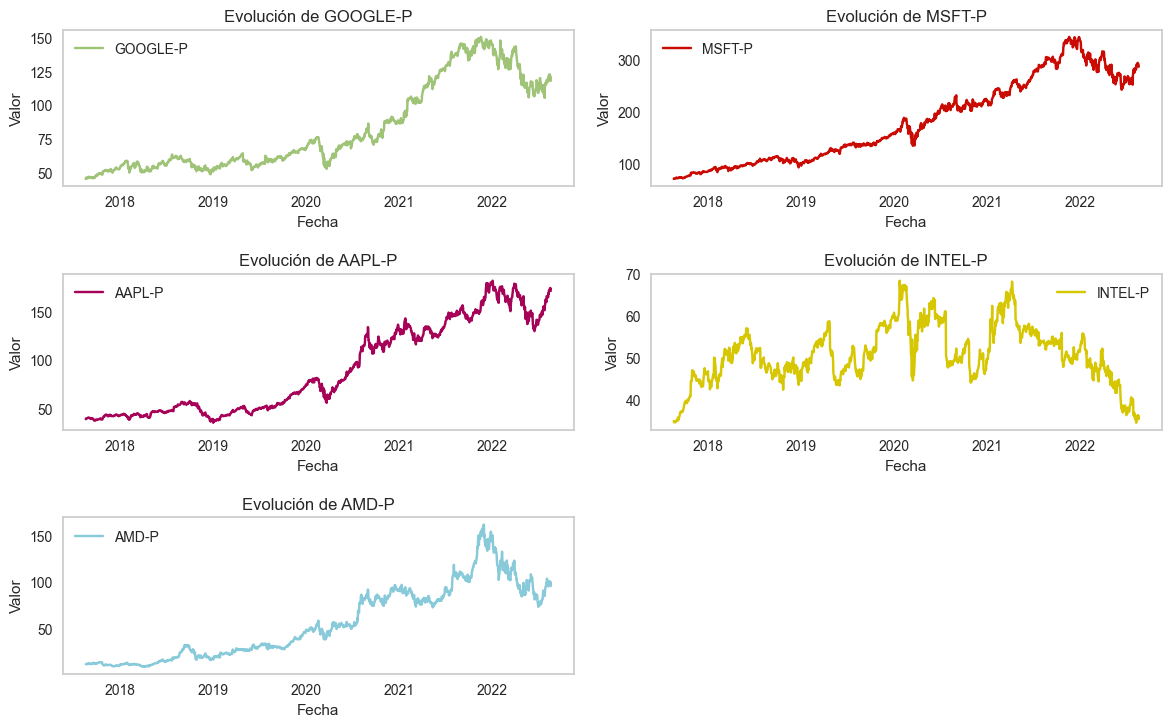

In [48]:
data.index = pd.to_datetime(data.index)

plt.figure(figsize=(12, 12))


variables_to_plot = ['GOOGLE-P', 'MSFT-P', 'AAPL-P', 'INTEL-P', 'AMD-P']

for i, var in enumerate(variables_to_plot, start=1):
    plt.subplot(len(variables_to_plot), 2, i)
    plt.plot(data.index, data[var], label=var, color=f"C{i}")
    plt.title(f'Evolución de {var}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show();

Despues de hacer el plot de las variables, "Empresa"-P que representan el valor de las acciones de las empresas al final del dia X podemos observar lo siguiente.
Si nos fijamos en google que en este problema sera nuestro target observamos un aumento del valor de sus acciones a lo largo de los años aunque a finales de 2022 hay un pequeño retroceso en su valor. Esta tendencia de augmento en el valor la vemos en la mayoria de variables excepto en intel que sucede todo lo contrario. Vemos una grafica muy inestable con muchos altibajos donde al final hay un retroceso muy grande.

Vamos a hacer las mismas graficas tanto con las variables de volumen de acciones que se intercambiaron asi como las variables GAP de cada empresa.

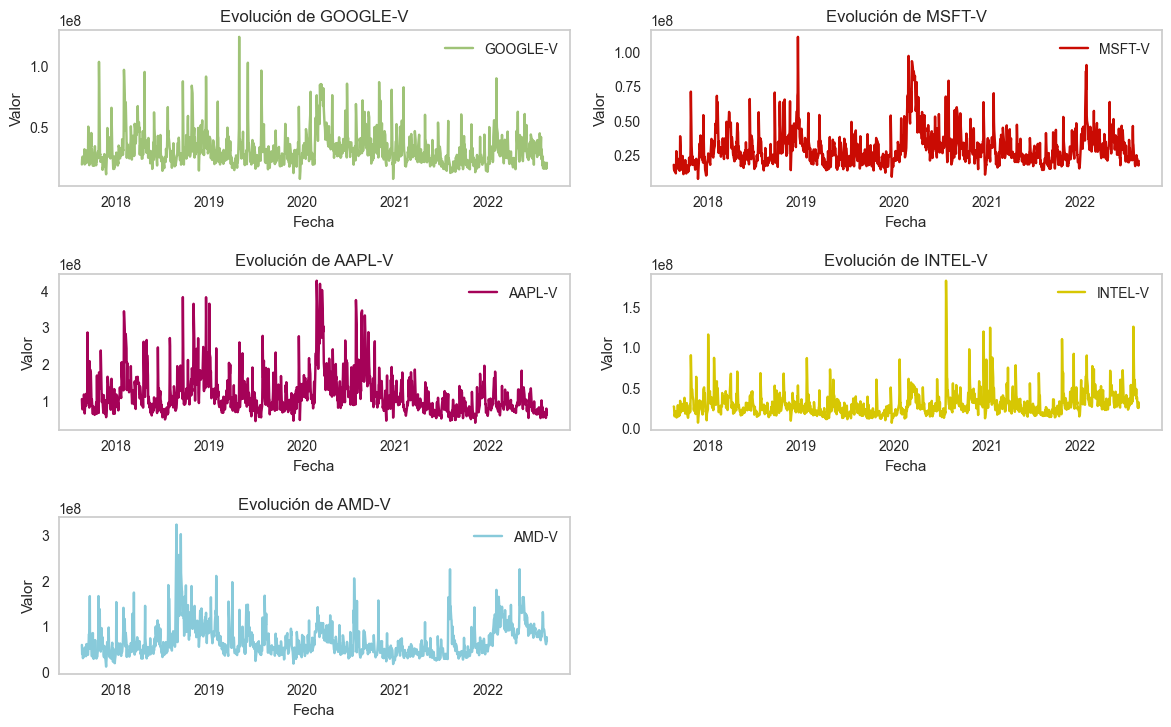

In [49]:
data.index = pd.to_datetime(data.index)

plt.figure(figsize=(12, 12))


variables_to_plot = ['GOOGLE-V', 'MSFT-V', 'AAPL-V', 'INTEL-V', 'AMD-V']

for i, var in enumerate(variables_to_plot, start=1):
    plt.subplot(len(variables_to_plot), 2, i)
    plt.plot(data.index, data[var], label=var, color=f"C{i}")
    plt.title(f'Evolución de {var}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show();

La variable de volumen tampoco nos aparta muchisima informacion pero podemos ver los picos de los intercambios de acciones de las empresas

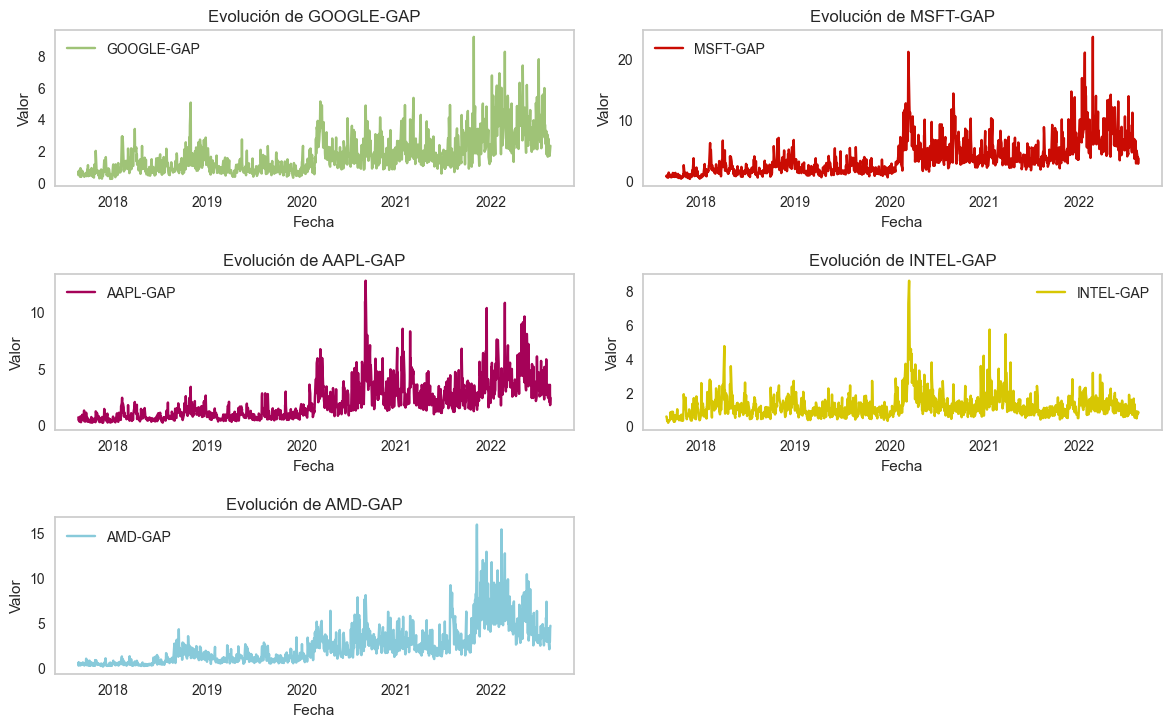

In [50]:
data.index = pd.to_datetime(data.index)

plt.figure(figsize=(12, 12))


variables_to_plot = ['GOOGLE-GAP', 'MSFT-GAP', 'AAPL-GAP', 'INTEL-GAP', 'AMD-GAP']

for i, var in enumerate(variables_to_plot, start=1):
    plt.subplot(len(variables_to_plot), 2, i)
    plt.plot(data.index, data[var], label=var, color=f"C{i}")
    plt.title(f'Evolución de {var}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show();

En el GAP vemos como a lo largo del tiempo este valor ha ido aumentando un poco. Aunque sigue habiendo picos mas altos o mas bajos en general su valor ha ido aumentando ligeramente. Todo esto a excepcion de intel que su GAP se ha quedado en una tendecia similar a lo largo del tiempo.

Vamos a observar la correlacion de los datos

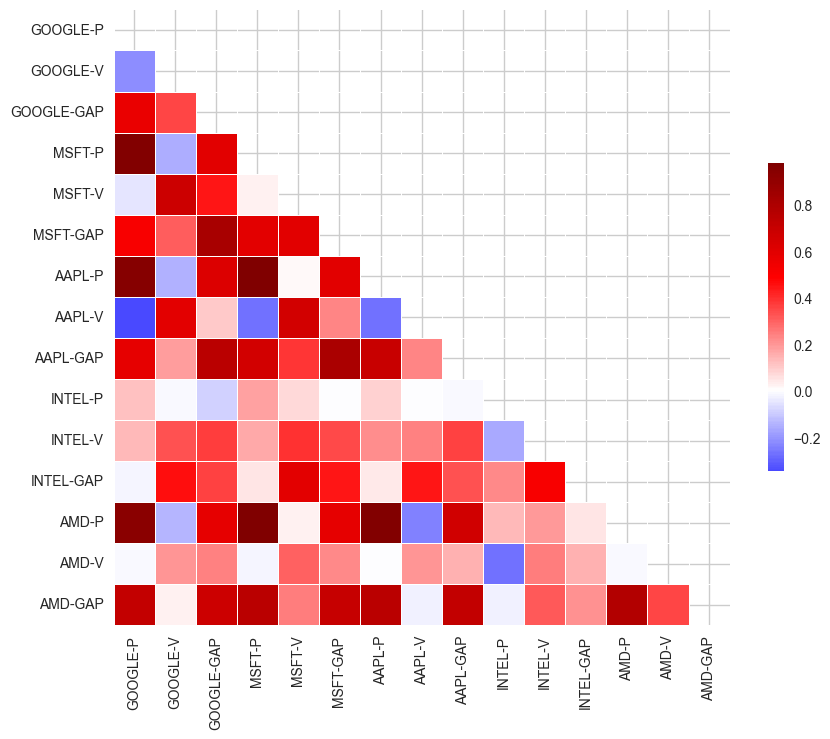

In [51]:
corr = data.corr(numeric_only=False)
mask = np.triu(np.ones_like(corr))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Observando la matriz de correlaciones diria que si que es posible predecir una variables a partir de otras. Vemos que las correlaciones de las variables son en general bastante fuertes. Si nos fijamos en nuestra variable objetivo podemos ver que todas las variables "Empresa"-P estan fuertemente relacionadas con nuestra objetivo. Eso si Intel-P es la que menos fuerte es. Por otro lado los volumenes de intercambio parecen no tener una correlacion muy fuerte o tienen una correlacion negativa con nuestra variable objetivo. Las variables GAPS tambien tienen una relacin directa muy fuerte con GOOGLE-P, excepto INTEL-GAp que parece no tener correlacion con nuestra variable objetivo. Las variables de volumen tienen una relacion directa entre ellas asi como las variables GAP. En general parece que la mayoria de variables, a excepcion de un par de ellas, presentan una correlacion directa fuerte unas con otras.

In [52]:
### Divideremos los datos en entrenamiento, validacion y test y los estandarizaremos

from sklearn.preprocessing import StandardScaler

train_data = data.iloc[:1000]
val_data = data.iloc[1000:1100]
test_data = data.iloc[1100:]

scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

train_data_scaled = pd.DataFrame(train_data_scaled, columns=data.columns, index = train_data.index)
val_data_scaled = pd.DataFrame(val_data_scaled, columns=data.columns, index = val_data.index)
test_data_scaled = pd.DataFrame(test_data_scaled, columns=data.columns, index = test_data.index)

Vamos a crear las ventanas temporales

In [53]:
window_size = 8

def create_windows(data, window_size):
  for c in data.columns:
    for i in range(window_size):
      data[f'{c}_t-{i}'] = data[c].shift(i)

    data = data.drop(c, axis=1)

  data = data.dropna(inplace=False)
  return data

train_data_scaled = create_windows(train_data_scaled, window_size)
val_data_scaled = create_windows(val_data_scaled, window_size)
test_data_scaled = create_windows(test_data_scaled, window_size)

X_train = train_data_scaled.drop('GOOGLE-P_t-0', axis=1)
y_train = train_data_scaled['GOOGLE-P_t-0']
X_val = val_data_scaled.drop('GOOGLE-P_t-0', axis=1)
y_val = val_data_scaled['GOOGLE-P_t-0']
X_test = test_data_scaled.drop('GOOGLE-P_t-0', axis=1)
y_test = test_data_scaled['GOOGLE-P_t-0']

X_train.head()

,GOOGLE-P_t-1,GOOGLE-P_t-2,GOOGLE-P_t-3,GOOGLE-P_t-4,GOOGLE-P_t-5,GOOGLE-P_t-6,GOOGLE-P_t-7,GOOGLE-V_t-0,GOOGLE-V_t-1,GOOGLE-V_t-2,...,AMD-V_t-6,AMD-V_t-7,AMD-GAP_t-0,AMD-GAP_t-1,AMD-GAP_t-2,AMD-GAP_t-3,AMD-GAP_t-4,AMD-GAP_t-5,AMD-GAP_t-6,AMD-GAP_t-7
Date,,,,,,,,,,,,,,,,,,,,,
2017-08-30,-1.081,-1.098,-1.093,-1.081,-1.068,-1.073,-1.115,-0.424,-0.595,-0.733,...,-0.746,-0.194,-0.853,-1.049,-0.947,-0.998,-0.998,-0.805,-1.064,-0.824
2017-08-31,-1.062,-1.081,-1.098,-1.093,-1.081,-1.068,-1.073,-0.043,-0.424,-0.595,...,-0.600,-0.746,-0.962,-0.853,-1.049,-0.947,-0.998,-0.998,-0.805,-1.064
2017-09-01,-1.039,-1.062,-1.081,-1.098,-1.093,-1.081,-1.068,-0.935,-0.043,-0.424,...,-0.796,-0.600,-0.907,-0.962,-0.853,-1.049,-0.947,-0.998,-0.998,-0.805
2017-09-05,-1.044,-1.039,-1.062,-1.081,-1.098,-1.093,-1.081,-0.358,-0.935,-0.043,...,-1.005,-0.796,-0.845,-0.907,-0.962,-0.853,-1.049,-0.947,-0.998,-0.998
2017-09-06,-1.064,-1.044,-1.039,-1.062,-1.081,-1.098,-1.093,-0.101,-0.358,-0.935,...,-0.847,-1.005,-0.991,-0.845,-0.907,-0.962,-0.853,-1.049,-0.947,-0.998


 Definimos el dataset y dataloader para torch

In [54]:
Google_train = torch.utils.data.DataLoader(NASDAQ(X_train.values, y_train.values), batch_size=32)
Google_val = torch.utils.data.DataLoader(NASDAQ(X_val.values, y_val.values), batch_size=32)
Google_test = torch.utils.data.DataLoader(NASDAQ(X_test.values, y_test.values), batch_size=32)

### APARTADO B

Vamos a ejecutar un modelo MLP con diferentes configuraciones y compararemos sus resultados.

In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_and_validate_model(train, val, hidden_sizes, activation, learning_rates, input_size, patience=10):
    results = {}

    for hidden_layers in hidden_sizes:
        for act in activation:
            for lr in learning_rates:
                print(f"Hidden layers: {hidden_layers}, activation: {act.__name__}, learning rate: {lr}")

                model = MLP(input_size, hidden_layers, act).to('cuda')
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                hist_loss = train_loop(model, train, val, optimizer, patience)
                model.eval()
                preds, true = test_model(model, val)

                mae = mean_absolute_error(true, preds)
                mse = mean_squared_error(true, preds)
                val_loss = hist_loss['val'][-1]
                

                key = f"{act.__name__}_{str(hidden_layers)}_{str(lr)}"
                results[key] = {
                    "mae": mae,
                    "mse": mse,
                    "final_val_loss": val_loss,
                    "history": hist_loss,
                    "model": model
                }

    return results

In [56]:
def results_and_best_model(res):
    best_model = sorted(res.items(), key=lambda x: x[1]['mse'])
    best = {"Model": [], "MSE": [], "MAE": [], "VAL_LOSS": []}

    for model, results in best_model:
        best["Model"].append(model)
        best["MSE"].append(results['mse'])
        best["MAE"].append(results['mae'])
        best["VAL_LOSS"].append(results['final_val_loss'])

    best = pd.DataFrame(best)

    cols = len(best["Model"])/4
    if cols - int(cols) > 0:
        cols +=1
    cols = int(cols)

    fig, axes = plt.subplots(cols, 4, figsize=(15, cols * 5))
    axes = axes.flatten()

    # Graficar curvas de entrenamiento y validación
    for i, (key, result) in enumerate(res.items()):
        history = result.get('history', None)
        if history:
            ax = axes[i]
            ax.plot(history['train'], label="Train Loss", color='blue')
            ax.plot(history['val'], label="Validation Loss", color='orange')
            ax.set_title(key)
            ax.set_xlabel("Épocas")
            ax.set_ylabel("Pérdida")
            ax.legend()
        else:
            axes[i].text(0.5, 0.5, "No history", ha='center', va='center')
            axes[i].set_title(key)
    plt.tight_layout()
    plt.show()


    print(f"Mejor modelo: {best_model[0][0]} con MSE = {best_model[0][1]['mse']}\n")
    print(best)

In [57]:
##FIJAMOS LA SEMILLA PARA QUE LOS RESULTADOS SEAN REPRODUCIBLES
torch.manual_seed(30)
np.random.seed(30)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(30)

input_size = X_train.shape[1]
patience = 10

hidden_sizes = [[32],[64], [128], [256], [512], [128,64], [256,128], [512, 256]]
activation = [nn.ReLU, nn.Sigmoid]

learning_rates = [1e-2,1e-3]

res = train_and_validate_model(Google_train, Google_val, hidden_sizes,activation, learning_rates, X_train.shape[1], patience)

Hidden layers: [32], activation: ReLU, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [32], activation: ReLU, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [32], activation: Sigmoid, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [32], activation: Sigmoid, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [64], activation: ReLU, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [64], activation: ReLU, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [64], activation: Sigmoid, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [64], activation: Sigmoid, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [128], activation: ReLU, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [128], activation: ReLU, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [128], activation: Sigmoid, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [128], activation: Sigmoid, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [256], activation: ReLU, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [256], activation: ReLU, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [256], activation: Sigmoid, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [256], activation: Sigmoid, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [512], activation: ReLU, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [512], activation: ReLU, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [512], activation: Sigmoid, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [512], activation: Sigmoid, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [128, 64], activation: ReLU, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [128, 64], activation: ReLU, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [128, 64], activation: Sigmoid, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [128, 64], activation: Sigmoid, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [256, 128], activation: ReLU, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [256, 128], activation: ReLU, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [256, 128], activation: Sigmoid, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [256, 128], activation: Sigmoid, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [512, 256], activation: ReLU, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [512, 256], activation: ReLU, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [512, 256], activation: Sigmoid, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [512, 256], activation: Sigmoid, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

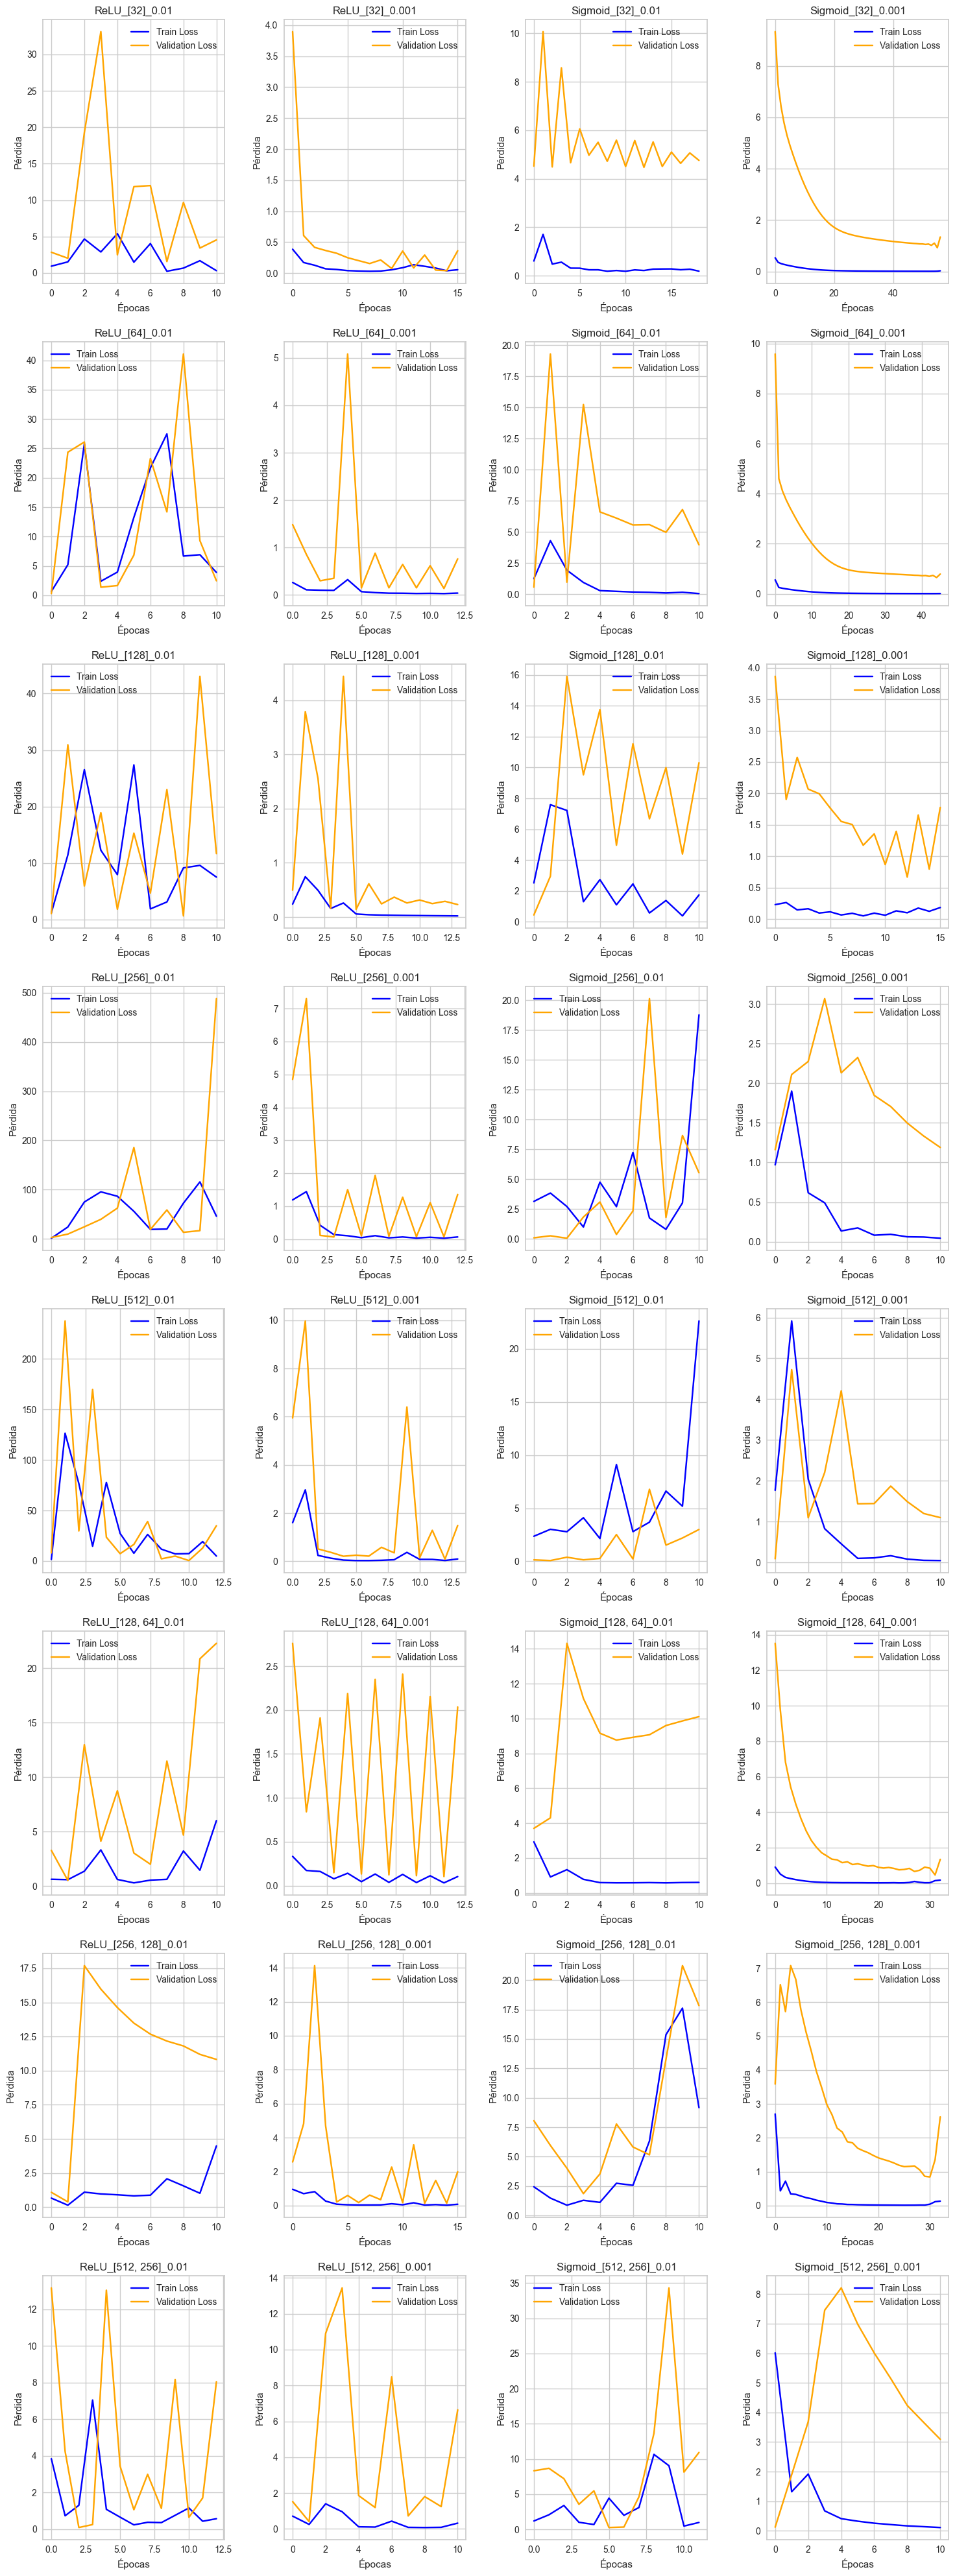

Mejor modelo: ReLU_[128]_0.001 con MSE = 0.14897072315216064

                       Model      MSE     MAE  VAL_LOSS
0           ReLU_[128]_0.001    0.149   0.332     0.230
1            ReLU_[32]_0.001    0.234   0.398     0.363
2            ReLU_[64]_0.001    0.498   0.669     0.759
3         Sigmoid_[64]_0.001    0.509   0.649     0.788
4        Sigmoid_[512]_0.001    0.709   0.778     1.097
5        Sigmoid_[256]_0.001    0.778   0.851     1.190
6         Sigmoid_[32]_0.001    0.862   0.839     1.339
7    Sigmoid_[128, 64]_0.001    0.865   0.854     1.337
8           ReLU_[256]_0.001    0.895   0.928     1.355
9           ReLU_[512]_0.001    0.982   0.971     1.488
10       Sigmoid_[128]_0.001    1.160   1.032     1.778
11     ReLU_[256, 128]_0.001    1.318   1.122     1.999
12      ReLU_[128, 64]_0.001    1.348   1.147     2.035
13            ReLU_[64]_0.01    1.641   1.184     2.470
14  Sigmoid_[256, 128]_0.001    1.689   1.202     2.616
15  Sigmoid_[512, 256]_0.001    2.037   1.

In [58]:
results_and_best_model(res)

Si observamos los resultados vemos que el modelo que mejor se comporta con nuestros datos de validacion es el que tiene por parametros:
- 1 sola capa de tamaño 128, usando ReLu como funcion de activacion y con un learning rate de 0.001. Como resultado obtenemos un MSE = 0.149, MAE = 0.332     

Si observamos los resultados vemos como en general los modelos que han usado un learning rate de 0.001 en vez de 0.01 obtienen muchos mejores resultados. Es decir que los learning rate altos nos podrian estar conduciendo a un sobreajuste de nuestros modelos. Por otro lado parece que no haya una funcion de activacion muy por encima de la otro, aunque ReLu obtiene los 3 mejores resultados, las dos funciones empleadas se reparten bastante bien entre los mejores resultados. Por ultimo si nos fijamos en el numero de capas y su tamaño, los mejores resultados los obtenemos cuando usamos una sola capa. Esto tambien se podria deber a un sobreajuste que hace nuestro modelo cuando usa diferentes capas.

Fijandos ahora en las diferentes graficas que tenemos para comparar el historial de peridida de las diferentes ejecuciones comparando el conjunto de test con el de validacion podemos ver que efectivamente nuestro mejor modelo es el descrito anteriormente. Este modelo es el que mejor ajusta, al final, la perdida entre el conjunto de test i el de validacion. as curvas de entrenamiento y validación siguen un comportamiento similar, donde ambas muestran una disminución en la pérdida a lo largo del tiempo. Esto indica que el modelo está aprendiendo y generalizando bien. Otros modelos donde se ajustan bien las dos metricas son ReLU_[32]_0.001 y ReLU_[64]_0.001, que precisamente completarian nuestro top3 de resultados obtenidos.

Vamos a evaluar al modelo con el conjunto de test para ver si se comporta mas o menos igual

In [69]:
res["ReLU_[128]_0.001"]["model"].eval()
preds, true = test_model(res["ReLU_[128]_0.001"]["model"], Google_test)

mae = mean_absolute_error(true, preds)
mse = mean_squared_error(true, preds)

print(f"MAE: {mae}")
print(f"MSE: {mse}")

MLP(
  (fc1): Linear(in_features=119, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=119, out_features=128, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MAE: 0.2854684293270111
MSE: 0.13451163470745087


Observamos que el conjunto de test sigue la tendencia del conjunto de validacion y obtiene un mae y mse muy similares (algo mejores), confirmando la no sobreespecializacion de nuestro modelo con datos nuevos

### APARTADO C

In [60]:
##FIJAMOS LA SEMILLA PARA QUE LOS RESULTADOS SEAN REPRODUCIBLES
torch.manual_seed(30)
np.random.seed(30)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(30)

    
input_size = X_train.shape[1]
patience = 10

hidden_sizes = [[128]]
activation = [nn.LeakyReLU, nn.SiLU]

learning_rates = [1e-2,1e-3]

res_c = train_and_validate_model(Google_train, Google_val, hidden_sizes,activation, learning_rates, X_train.shape[1], patience)

Hidden layers: [128], activation: LeakyReLU, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [128], activation: LeakyReLU, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [128], activation: SiLU, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [128], activation: SiLU, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

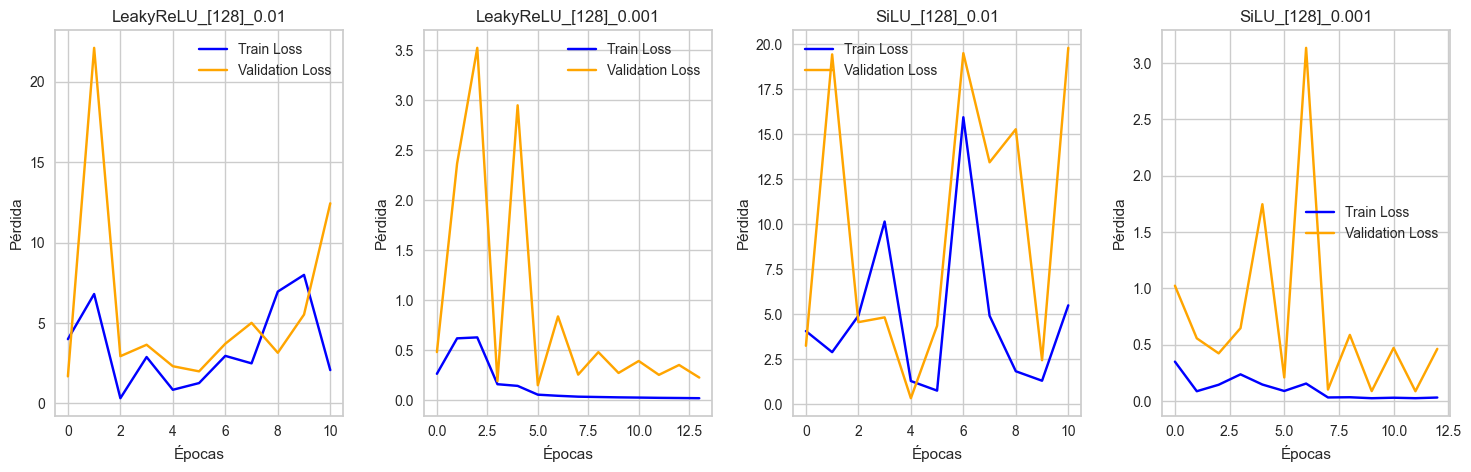

Mejor modelo: LeakyReLU_[128]_0.001 con MSE = 0.14722904562950134

                   Model     MSE    MAE  VAL_LOSS
0  LeakyReLU_[128]_0.001   0.147  0.319     0.227
1       SiLU_[128]_0.001   0.303  0.512     0.464
2   LeakyReLU_[128]_0.01   8.200  2.713    12.442
3        SiLU_[128]_0.01  12.952  3.489    19.788


In [61]:
results_and_best_model(res_c)

En este caso si fijamos el tamaño de las capas segun los resultados obtenidos en el apartado b y experimentamos con LeakyReLU y SiLU obtenemos los resultados siguientes:
*   La mejor configuracion es usando leakyReLU con learning rate de 0.001. Seguimos observando como un learning rate mas bajo contribuye a mejores resutados. En este caso por mucho. En este caso se observa lo que podria ser un gran sobreespecializacion cuando el learning rate es de 0.010

* SiLU no ha sacado malos resultados tampoco aunque LeakyReLU en nuestro caso y con nuestra configuracion ha sido mucho mejor.

Vamos a probar la configuracion encontrada con el conjunto de test para ver que sigue la tendencia del conjunto de validacion.

In [70]:
res_c["LeakyReLU_[128]_0.001"]["model"].eval()
preds, true = test_model(res_c["LeakyReLU_[128]_0.001"]["model"], Google_test)

mae = mean_absolute_error(true, preds)
mse = mean_squared_error(true, preds)

print(f"MAE: {mae}")
print(f"MSE: {mse}")

MLP(
  (fc1): Linear(in_features=119, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=119, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MAE: 0.3644484579563141
MSE: 0.21884682774543762


El conjunto en general obteniene en las predicciones resultados en la tendencia del conjunto de validacion. El mse y el mae obtienen valores muy similares a la ejecucion con el conjunto de validacion. En este caso sobretodo si observamos el conjunto de validacion podriamos decir que LeakyReLU obtiene un resultado mejor del que teniamos hasta ahora con nuestro mejor funcion de activacion hasta el momento que era ReLu. Los resultados son extremadamente similares con lo que para el siguiente apartado probaremos tanto con ReLU como con LeakyReLU.

### Apartado D

In [63]:
try:
  from apafib import load_Google
  data_d = load_Google()
  data_d.index = pd.to_datetime(data_d.index)

except:
  print("No se ha podido cargar el dataset")
    

data_d['day'] = data_d.index.day
data_d['month'] = data_d.index.month
data_d['year'] = data_d.index.year
data_d['day_of_week'] = data_d.index.dayofweek                 
data_d['week_of_year'] = data_d.index.isocalendar().week

#data_d['day_of_week_sin'] = np.sin(2 * np.pi * data_d['day_of_week'] / 7)
#data_d['day_of_week_cos'] = np.cos(2 * np.pi * data_d['day_of_week'] / 7)
#data_d['month_sin'] = np.sin(2 * np.pi * data_d['month'] / 12)
#data_d['month_cos'] = np.cos(2 * np.pi * data_d['month'] / 12)

cols = ['day', 'month', 'year', 'day_of_week', 'week_of_year', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos']


data_d.head()
### Divideremos los datos en entrenamiento, validacion y test y los estandarizaremos

from sklearn.preprocessing import StandardScaler

train_data_d = data_d.iloc[:1000]
val_data_d = data_d.iloc[1000:1100]
test_data_d = data_d.iloc[1100:]

scaler = StandardScaler()
train_data_scaled_d = scaler.fit_transform(train_data_d)
val_data_scaled_d = scaler.transform(val_data_d)
test_data_scaled_d = scaler.transform(test_data_d)

train_data_scaled_d = pd.DataFrame(train_data_scaled_d, columns=data_d.columns, index = train_data_d.index)
val_data_scaled_d = pd.DataFrame(val_data_scaled_d, columns=data_d.columns, index = val_data_d.index)
test_data_scaled_d = pd.DataFrame(test_data_scaled_d, columns=data_d.columns, index = test_data_d.index)

,GOOGLE-P,GOOGLE-V,GOOGLE-GAP,MSFT-P,MSFT-V,MSFT-GAP,AAPL-P,AAPL-V,AAPL-GAP,INTEL-P,INTEL-V,INTEL-GAP,AMD-P,AMD-V,AMD-GAP,day,month,year,day_of_week,week_of_year
Date,,,,,,,,,,,,,,,,,,,,
2017-08-21,45.333,18846560,0.480,72.15,17698800,0.78,39.303,105320280,0.695,34.92,26479700,0.58,12.05,58786300,0.560,21,8,2017,0,34
2017-08-22,46.234,23326400,0.719,73.16,14333220,0.89,39.945,86259560,0.495,34.65,26093400,0.57,12.17,38946780,0.230,22,8,2017,1,34
2017-08-23,46.350,21771500,0.528,72.72,13758650,0.62,39.995,77507760,0.398,34.66,19775620,0.43,12.48,44193270,0.585,23,8,2017,2,34
2017-08-24,46.064,25323820,0.767,72.69,17097240,0.79,39.818,79128680,0.547,34.71,14283180,0.34,12.50,37161680,0.320,24,8,2017,3,34
2017-08-25,45.794,21055280,0.503,72.82,12790300,0.87,39.965,100738400,0.322,34.67,14714810,0.35,12.43,29650370,0.320,25,8,2017,4,34


In [64]:
window_size = 8

def create_windows(data, window_size):
  for c in data.columns:
    if c not in cols:
      for i in range(window_size):
        data[f'{c}_t-{i}'] = data[c].shift(i)

      data = data.drop(c, axis=1)

  data = data.dropna(inplace=False)
  return data

train_data_scaled_d = create_windows(train_data_scaled_d, window_size)
val_data_scaled_d = create_windows(val_data_scaled_d, window_size)
test_data_scaled_d = create_windows(test_data_scaled_d, window_size)

X_train_d = train_data_scaled_d.drop('GOOGLE-P_t-0', axis=1)
y_train_d = train_data_scaled_d['GOOGLE-P_t-0']
X_val_d = val_data_scaled_d.drop('GOOGLE-P_t-0', axis=1)
y_val_d = val_data_scaled_d['GOOGLE-P_t-0']
X_test_d = test_data_scaled_d.drop('GOOGLE-P_t-0', axis=1)
y_test_d = test_data_scaled_d['GOOGLE-P_t-0']

X_train_d.head()

Google_train_d = torch.utils.data.DataLoader(NASDAQ(X_train_d.values, y_train_d.values), batch_size=32)
Google_val_d = torch.utils.data.DataLoader(NASDAQ(X_val_d.values, y_val_d.values), batch_size=32)
Google_test_d = torch.utils.data.DataLoader(NASDAQ(X_test_d.values, y_test_d.values), batch_size=32)

,day,month,year,day_of_week,week_of_year,GOOGLE-P_t-1,GOOGLE-P_t-2,GOOGLE-P_t-3,GOOGLE-P_t-4,GOOGLE-P_t-5,...,AMD-V_t-6,AMD-V_t-7,AMD-GAP_t-0,AMD-GAP_t-1,AMD-GAP_t-2,AMD-GAP_t-3,AMD-GAP_t-4,AMD-GAP_t-5,AMD-GAP_t-6,AMD-GAP_t-7
Date,,,,,,,,,,,,,,,,,,,,,
2017-08-30,1.623,0.430,-1.753,-0.013,0.558,-1.081,-1.098,-1.093,-1.081,-1.068,...,-0.746,-0.194,-0.853,-1.049,-0.947,-0.998,-0.998,-0.805,-1.064,-0.824
2017-08-31,1.737,0.430,-1.753,0.701,0.558,-1.062,-1.081,-1.098,-1.093,-1.081,...,-0.600,-0.746,-0.962,-0.853,-1.049,-0.947,-0.998,-0.998,-0.805,-1.064
2017-09-01,-1.685,0.721,-1.753,1.414,0.558,-1.039,-1.062,-1.081,-1.098,-1.093,...,-0.796,-0.600,-0.907,-0.962,-0.853,-1.049,-0.947,-0.998,-0.998,-0.805
2017-09-05,-1.229,0.721,-1.753,-0.726,0.625,-1.044,-1.039,-1.062,-1.081,-1.098,...,-1.005,-0.796,-0.845,-0.907,-0.962,-0.853,-1.049,-0.947,-0.998,-0.998
2017-09-06,-1.115,0.721,-1.753,-0.013,0.625,-1.064,-1.044,-1.039,-1.062,-1.081,...,-0.847,-1.005,-0.991,-0.845,-0.907,-0.962,-0.853,-1.049,-0.947,-0.998


In [65]:
##FIJAMOS LA SEMILLA PARA QUE LOS RESULTADOS SEAN REPRODUCIBLES
torch.manual_seed(30)
np.random.seed(30)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(30)

input_size = X_train_d.shape[1]
patience = 10

hidden_sizes = [[128]]
activation = [nn.LeakyReLU, nn.ReLU]

learning_rates = [1e-2,1e-3]

res_d = train_and_validate_model(Google_train_d, Google_val_d, hidden_sizes,activation, learning_rates, X_train_d.shape[1], patience)

Hidden layers: [128], activation: LeakyReLU, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [128], activation: LeakyReLU, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [128], activation: ReLU, learning rate: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden layers: [128], activation: ReLU, learning rate: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

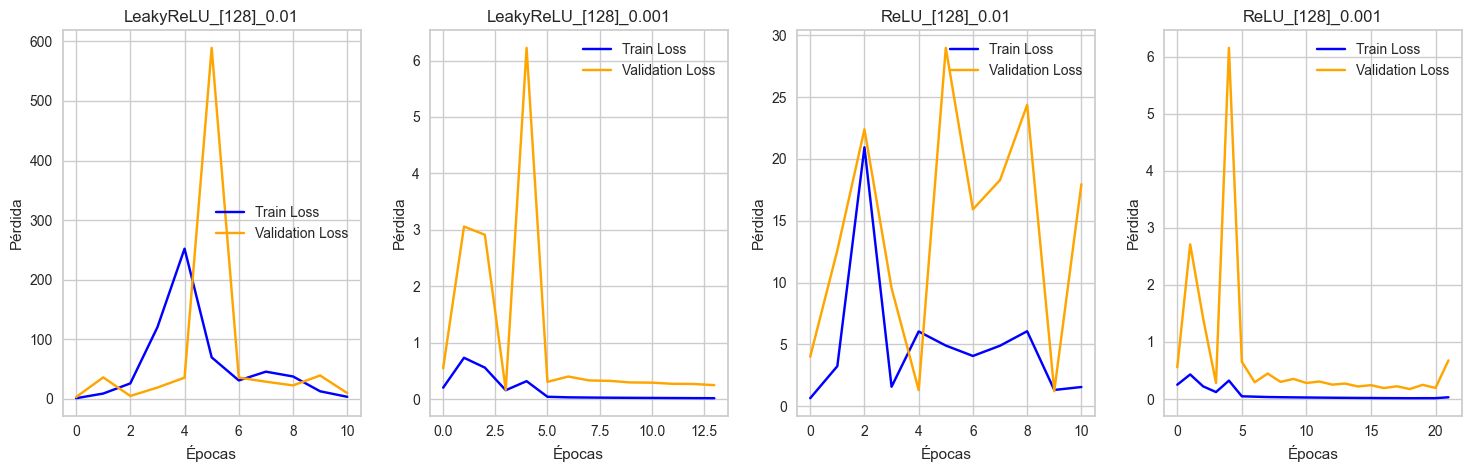

Mejor modelo: LeakyReLU_[128]_0.001 con MSE = 0.1617869883775711

                   Model     MSE    MAE  VAL_LOSS
0  LeakyReLU_[128]_0.001   0.162  0.348     0.250
1       ReLU_[128]_0.001   0.443  0.628     0.677
2   LeakyReLU_[128]_0.01   6.587  2.552     9.829
3        ReLU_[128]_0.01  11.747  3.301    17.954


In [66]:
results_and_best_model(res_d)

Añadiendo las variables temporales vemos que de primeras no mejoran las metricas de las ejecuciones anteriores. En este caso Leaky ha sido mejor que ReLU con diferencia. PEro aun asi como decimos el mse y el mae se han quedado mu cerca de resultados anteriores pero no lo han mejorado. Esto puede deberse a que estas nuevas variables son poco informativas o hay alguno mas informativa que otra y con las que no son informativas puede que este sobreajustando el modelo.

Vamos a ver como se comporta nuestro modelo con el conjunto de test

In [67]:
res_d["LeakyReLU_[128]_0.001"]["model"].eval()
preds, true = test_model(res_d["LeakyReLU_[128]_0.001"]["model"], Google_test_d)

mae = mean_absolute_error(true, preds)
mse = mean_squared_error(true, preds)

print(f"MAE: {mae}")
print(f"MSE: {mse}")

MLP(
  (fc1): Linear(in_features=124, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=124, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)

MAE: 0.27365851402282715
MSE: 0.12485887855291367


Vemos que el conjunto de test sigue la tendecia del conjunto de validacion e incluso saca resultados un poco mejores. Podriamos decir que puede que nos convenga usar este ultimo modelo que usa el dataset con las variables temporales. Esto se debe a que en nuestro problema estas variables tienen un peso en el valor final de las acciones. Y aunque el reultado a priori sea un poco peor de lo que teniamos si estas variables, puede que a futuro nos sea util tenerlas y mejoren nuestro modelo. Con lo que en conclusion me qudaria con este ultimo modelo usando LeakyReLu con lr de 0.001 una capa de tamaño 128 e insertando el dataset las variables temporales.

### APARTADO E

In [68]:
persistence_predictions = X_test['GOOGLE-P_t-1'].values
persistence_true = y_test

mae = mean_absolute_error(persistence_true, persistence_predictions)
mse = mean_squared_error(persistence_true, persistence_predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")

MAE: 0.10779670174888537
MSE: 0.018564573477702895


Por ultimo hemos usado un modelo de persistencia para saber si nuestro modelo esta prediciendo algo. Podemos ver que el mae y el mse de este modelo de persistencia es muy muy bajo comparado con los resultados de nuestro modelo. Por eso diria que el modelo si que esta prediciendo o intentando predecir algo. Cabe destacar que el mae y el mse son muy pequeños en este modelo de persistencia ya que al tratarse de empresas muy muy grandes los cambios en los valores de las acciones de un dia para otro no son demasiado grandes. Puede que nuestro modelo sufra de un sobreajuste, y que no logre capturar bien ciertas relaciones entre las variables o que tenga demasiadas variables con las que predecir.